<a href="https://colab.research.google.com/github/michaelmml/Word-Generation/blob/main/TrainableTransformerImageCaption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

In [2]:
import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

In [3]:
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [4]:
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
image_path = "/content/drive/My Drive/ImageCaption/Flicker8k/Images"
dir_Flickr_text = "/content/drive/My Drive/ImageCaption/Flicker8k/captions.txt"

In [8]:
root_folder = '/content/drive/My Drive/ImageCaption'

Load image function to utilise **InceptionV3** and instantiate model.

In [9]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Load Image Links

In this example, we are still using the Flickr database and creating the dataframe of links as from the file.

In [11]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split(',')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])
data = data.reindex(columns =['filename','caption'])
data = data.drop(data.index[0])
uni_filenames = np.unique(data.filename.values)

In [12]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = image_path + "/" + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/drive/My Drive/ImageCaption/Flicker8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/My Drive/ImageCaption/Flicker8k/Images/1001773457_577c3a7d70.jpg']

**Import Transformer Modules - Encodings, Encoder, Decoder, Layers, etc.**

In [13]:
import sys
sys.path.append(root_folder)

In [14]:
import TransformerArchitecture
from TransformerArchitecture import *

**Adapted model, in particular for 2D positional encoding.**

In [15]:
top_k = 5000
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [16]:
def reload_model():
    # Clean the session
    tf.keras.backend.clear_session()
    # Create the Transformer model
    transformer = Transformer(num_layer, d_model, num_heads, dff, row_size, col_size, target_vocab_size, max_pos_encoding=target_vocab_size, rate=dropout_rate)
    
    ckpt = tf.train.Checkpoint(transformer=transformer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, root_folder, max_to_keep=2)

    if ckpt_manager.latest_checkpoint:
      ckpt.restore(ckpt_manager.latest_checkpoint)
      print("Last checkpoint restored.")
    
    return transformer

In [17]:
transformer = reload_model()

Last checkpoint restored.


In [19]:
import pickle

with open(root_folder+"/tokenizer.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)

In [22]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [20]:
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result, tf.squeeze(output, axis=0), attention_weights

Predicted Caption: two dogs run through the grass


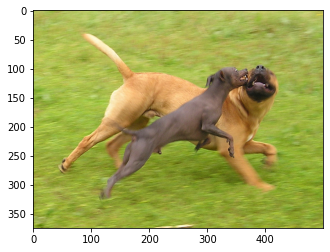

In [23]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
rid = np.random.randint(0, len(all_img_name_vector))
image = all_img_name_vector[rid]

caption, result, attention_weights = evaluate(image)

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)